In [71]:
import sys
import math
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from eda.helper_functions.visualisations import multiplots_freq, multiplots_freq_target, create_corr_matrix

| Column    |           Name          |     Type    |                                  Description                                      |
| --------- | ----------------------- | ----------- | --------------------------------------------------------------------------------- |
| age       | Age                     | Int         | Age of patient                                                                    |
| sex       | Sex                     | Binary      | Sex of patient                                                                    |
| cp        | Chest Pain Type         | Category    | (1 = Typical Angina; 2 = Atypical Angina; 3 = Non-Anginal Pain; 4 = Asymptomatic) |
| restbp    | Resting Blood Pressure  | Int         | Resting blood pressure (in mm Hg on admission to the hospital)                    |
| chol      | Serum Cholestoral       | Int         | Serum cholestoral in mg/dl                                                        |
| fbs       | Fasting Blood Sugar     | Binary      | True if fasting blood sugar > 120 mg/dl else False                                |
| restecg   | Resting ECG             | Category    | (0 = Normal; 1 = Abnormal ST-T wave; 2 = Probable hypertrophy*)                   | 
| thalach   | Max Heart Rate          | Int         | Maximum heart rate achieved                                                       |
| exang     | Exercise Induced Angina | Binary      | Exercise induced angina: (1 = Yes; 0 = No)                                        |
| oldpeak   | ST depression           | Float       | ST depression induced by exercise relative to rest                                |
| slope     | ST Segment Slope        | Category    | Slope of the peak exercise ST segment (1 = Upsloping; 2 = Flat; 3 = Downsloping)  |
| ca        | No. of Major Vessels    | Int         | Number of major vessels (0-3) coloured by flourosopy                              |
| thal      | Thalassemia             | Category    | Status of blood disorder (3 = Normal; 6 = Fixed Defect; 7 = Reversable Defect     |
| target    | Diagnosis               | Category    | Heart Disease Diagnosis (0 = Absence; [1, 2, 3, 4] = Presence                     |

Diagnosis of Heart Disease: https://www.nhs.uk/conditions/coronary-heart-disease/diagnosis/
    
The process of diagnosing heart disease can be time sensitive. This work intends to highlight the predictive power of variables based on time constraints. This will put more emphasis on the performance of precision over recall. To discuss the time constraints that may be subject in this analysis, we will look throught the metrics and data we are provided for each patient and construct a basic timeline of events. Since we do not have access to an expert, the following information is based on research and assumptions and should be verified by an expert.

There are 4 main categories of information extraction and collection which will be relevant here: 

- Questionnaire: Face-to-face or over the phone questioning.
- Expert Evaluation: Evaluation by an expert
- Medical Evaluation: Evaluation using medical tools
- Historical: We may be able to rely on information that is recorded in the patients files, but this may be out of date.

| Column    |      Data Collection Method (Apparatus/ Procedure)     |   Estimated Time Taken   |                                         Ref                                                      |
| --------- | ------------------------------------------------------ | ------------------------ | ------------------------------------------------------------------------------------------------ |
| age       | Questionnaire/ Historical                              | 1m                       |                                                                                                  |
| sex       | Questionnaire/ Historical                              | 1m                       |                                                                                                  |
| cp        | Expert Evaluation                                      | 5m                       | https://www.ahajournals.org/doi/10.1161/JAHA.119.015539                                          |
| restbp    | Medical Evaluation (Sphygmomanometer)                  | 5m                       | https://www.nhs.uk/conditions/blood-pressure-test/                                               |
| chol      | Medical Evaluation (Blood test)                        | 10m                      | https://www.nhlbi.nih.gov/health-topics/blood-tests                                              |
| fbs       | Medical Evaluation (Blood test)                        | 8-10hrs (minimum)        | https://www.diabetes.co.uk/diabetes_care/fasting-blood-sugar-levels.html                         |
| restecg   | Medical Evaluation (electrocardiogram (ECG)            | 10m                      | https://www.nhs.uk/conditions/electrocardiogram/                                                 |
| thalach   | Questionnaire/ Historical                              | 1m                       | https://www.mayoclinic.org/healthy-lifestyle/fitness/in-depth/exercise-intensity/art-20046887    |
| exang     | Medical Evaluation (Treadmill electrocardiogram (ECG)) | 12hrs                    | https://www.health.harvard.edu/heart-health/angina-symptoms-diagnosis-and-treatments             |
| oldpeak   | Medical Evaluation (Treadmill electrocardiogram (ECG)) | 12hrs                    | https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4958709/                                            |
| slope     | Medical Evaluation (Treadmill electrocardiogram (ECG)) | 12hrs                    | https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4958709/                                            |
| ca        | Medical Evaluation (Flouroscopy)                       | 10m - 2hrs               | https://www.healthcareimaging.com.au/services/fluoroscopic-screening/                            |
| thal      | Medical Evaluation (Blood test)                        | 10m                      | https://kidshealth.org/en/parents/test-electrophoresis.html                                      |

*The references that we use to collect information are normally informative websites as they take us through the process for diagnosis and preparation.*

# Our Data

In [92]:
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
HEADERS = ['age', 'sex', 'cp', 'restbp', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

In [93]:
df = pd.read_csv(URL, names = HEADERS)
df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


## Split Dataset

In [94]:
train_test_df, val_df = train_test_split(df, test_size=0.1, stratify=df.target, random_state=1234)

In [95]:
print(train_test_df.shape, val_df.shape)

(272, 14) (31, 14)


## Missing Values

It is advised in the description of the data that missing values are identified as (-9) from further reading into dataset. However, when we perform EDA on this dataset, while we don't come across any missing values identified by (-9), we do come across several values labelled with a question mark (?). The following graphs show the missing data as identified by this value instead. In smaller datasets we want to keep the most observations that we can however with that comes the issue of imputing values that aren't representative of the population. In smaller sets of data, unique occurences of variable combinations are more likely to occur. Therefore, if we were to impute the values based on those surrounding them, we could be artificially manipulating the outcome.

<ipython-input-96-b83172cfded0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_df['thal'] = train_test_df['thal'].replace(['?'], np.nan)
<ipython-input-96-b83172cfded0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_df['ca'] = train_test_df['ca'].replace(['?'], np.nan)


<AxesSubplot:>

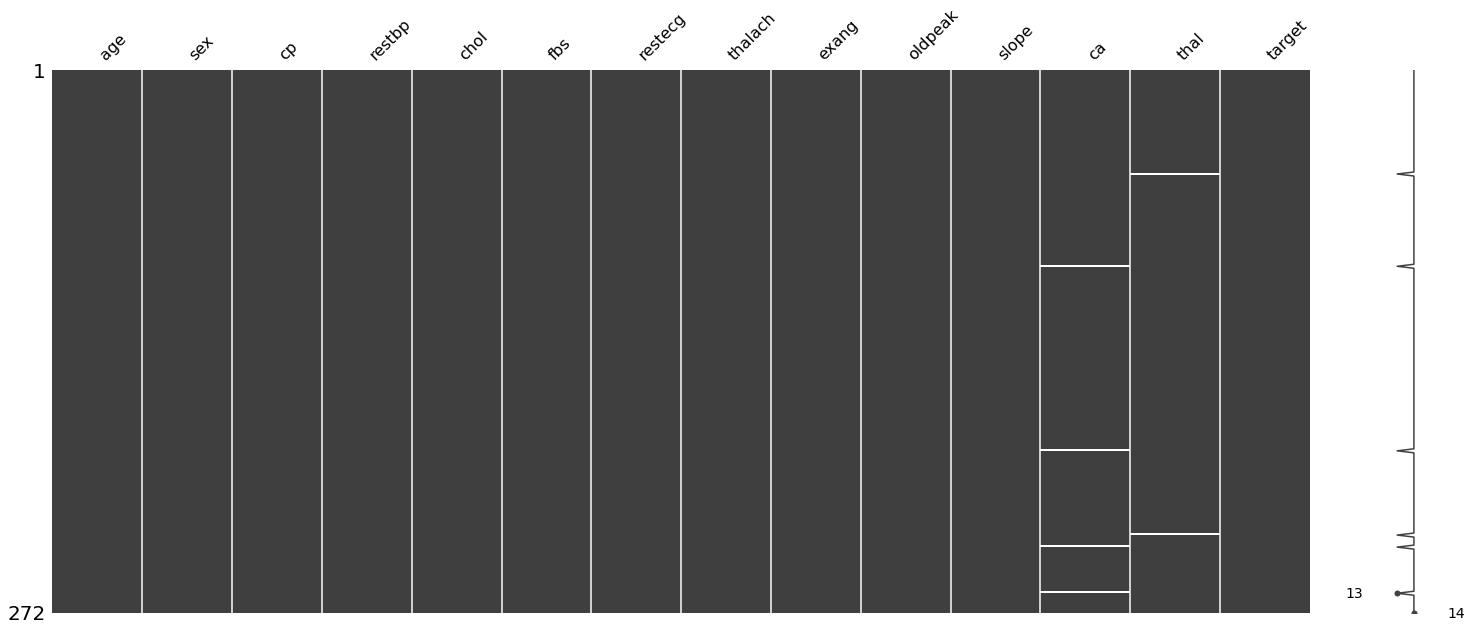

In [96]:
train_test_df['thal'] = train_test_df['thal'].replace(['?'], np.nan)
train_test_df['ca'] = train_test_df['ca'].replace(['?'], np.nan)
msno.matrix(train_test_df)

<AxesSubplot:>

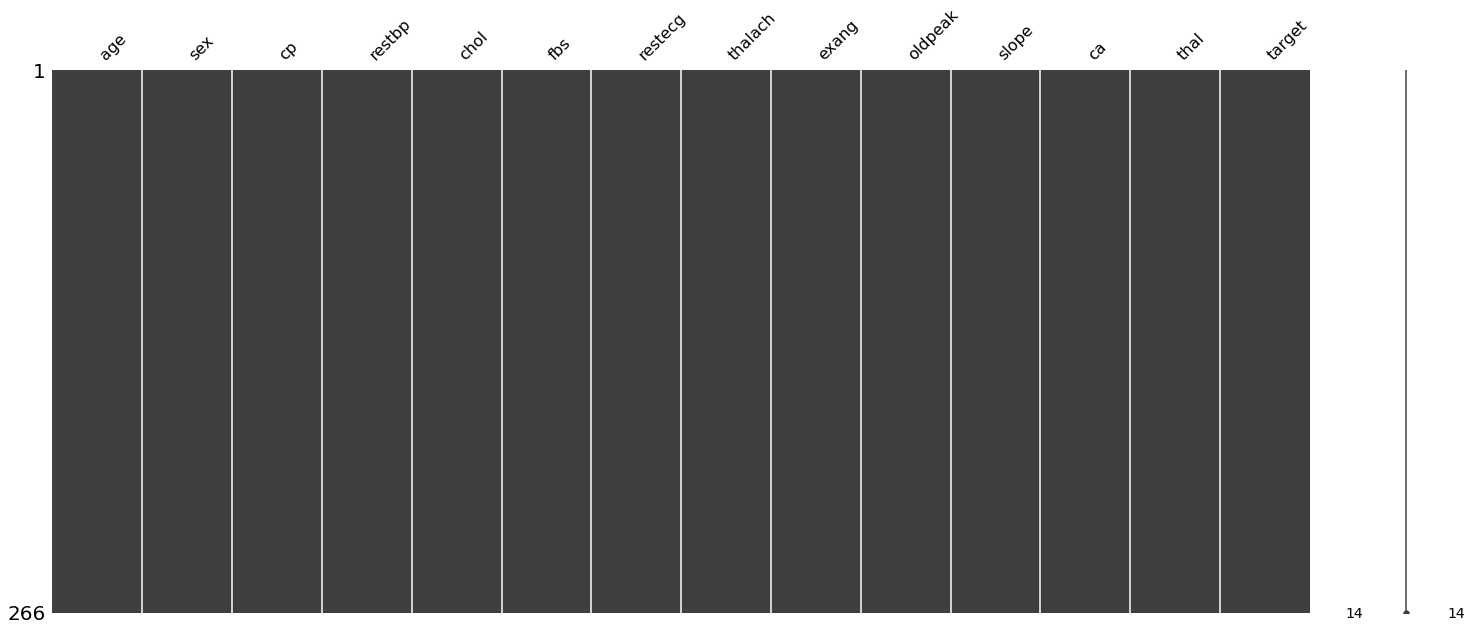

In [97]:
train_test_df = train_test_df.dropna()
msno.matrix(train_test_df)

Notes:
No missing data

## Exploratory Data Analysis

In [98]:
NUM_COLS = ['age', 'sex', 'restbp', 'chol', 'thalach', 'oldpeak']
CAT_COLS = ['cp', 'restecg', 'ca', 'slope', 'thal']

In [99]:
train_test_df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
281,47.0,1.0,3.0,130.0,253.0,0.0,0.0,179.0,0.0,0.0,1.0,0.0,3.0,0
65,60.0,1.0,4.0,145.0,282.0,0.0,2.0,142.0,1.0,2.8,2.0,2.0,7.0,2
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
158,60.0,1.0,4.0,140.0,293.0,0.0,2.0,170.0,0.0,1.2,2.0,2.0,7.0,2
34,44.0,1.0,3.0,130.0,233.0,0.0,0.0,179.0,1.0,0.4,1.0,0.0,3.0,0


### Let's take a look our target feature

The first variable that we need to look into is the target. The target provides us with information such as the data type, the spread, if there are any imbalances and we may also make changes based on prior information about the subject. In this example, we can see an imbalance in the dataset, particularly between the absence (0) of a diagnosis of heart disease and the presence in varying states (1,2,3,4).

<AxesSubplot:>

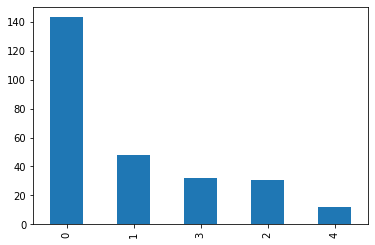

In [100]:
train_test_df['target'].value_counts().plot(kind='bar')

Therefore, the first change that will benefit the model is to combine the varying states of presence of heart disease since our dataset is relatively small. Now we can see the classes are more balanced but not matched. These slight imbalances will be addressed later on in the process.

<AxesSubplot:>

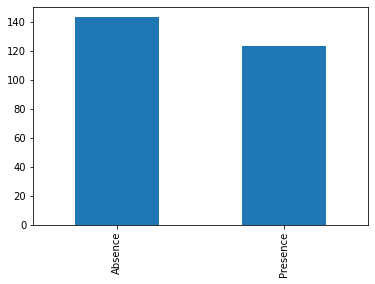

In [101]:
train_test_df['target'] = train_test_df['target'].apply(lambda x: 'Absence' if x == 0 else 'Presence')
train_test_df['target'].value_counts().plot(kind='bar')

### Let's get an overview of our numerical values

In [102]:
train_test_df[NUM_COLS].describe()

,age,sex,restbp,chol,thalach,oldpeak
count,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000
mean,54.500000,0.680451,132.097744,248.409774,149.650376,1.067669
std,8.959553,0.467181,17.701664,53.003963,22.963505,1.173644
min,29.000000,0.000000,94.000000,126.000000,88.000000,0.000000
25%,48.000000,0.000000,120.000000,211.000000,132.000000,0.000000
50%,55.000000,1.000000,130.000000,243.000000,153.000000,0.800000
75%,60.750000,1.000000,140.000000,276.750000,165.000000,1.800000
max,77.000000,1.000000,200.000000,564.000000,202.000000,6.200000


### Let's get an overview of our categorical values

In [103]:
for col in CAT_COLS:
    train_test_df[col] = train_test_df[col].astype("object")

In [104]:
train_test_df[CAT_COLS].describe()

,cp,restecg,ca,slope,thal
count,266.0,266.0,266,266.0,266
unique,4.0,3.0,4,3.0,3
top,4.0,2.0,0.0,2.0,3.0
freq,131.0,135.0,158,124.0,143


## Visualising Data

In [105]:
readable_df = train_test_df.copy()

#Convert values to a more readable format
readable_df['sex'] = readable_df['sex'].apply(lambda x: 'male' if x == 1 else 'female')

chest_pain_vals = {1.0: 'Typical Angina', 2.0: 'Atypical Angina', 3.0: 'Non-anginal Pain', 4.0: 'Asymptomatic'}
readable_df['cp'] = readable_df['cp'].apply(lambda x: chest_pain_vals[float(x)])

readable_df['fbs'] = readable_df['fbs'].apply(lambda x: 'above 120mg/dl' if x == 1 else 'below 120mg/dl')

restecg_vals = {0.0: 'Normal', 1.0: 'ST-T Wave Abnormality', 2.0: 'Probable Hypertrophy'}
readable_df['restecg'] = readable_df['restecg'].apply(lambda x: restecg_vals[float(x)])

readable_df['exang'] = readable_df['exang'].apply(lambda x: 'true' if x == 1 else 'false')

slope_vals = {1.0: 'Upsloping', 2.0: 'Flat', 3.0: 'Downsloping'}
readable_df['slope'] = readable_df['slope'].apply(lambda x: slope_vals[float(x)])

ca_vals = {0.0: '0 Major Valves', 1.0: '1 Major Valves', 2.0: '2 Major Valves', 3.0: '3 Major Valves'}
readable_df['ca'] = readable_df['ca'].apply(lambda x: ca_vals[float(x)])

thal_vals = {3.0: 'Normal', 6.0: 'Fixed Defect', 7.0: 'Reversable Defect'}
readable_df['thal'] = readable_df['thal'].apply(lambda x: thal_vals[float(x)])

for col in CAT_COLS:
    readable_df[col] = readable_df[col].astype("object")

In [106]:
readable_df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
281,47.0,male,Non-anginal Pain,130.0,253.0,below 120mg/dl,Normal,179.0,false,0.0,Upsloping,0 Major Valves,Normal,Absence
65,60.0,male,Asymptomatic,145.0,282.0,below 120mg/dl,Probable Hypertrophy,142.0,true,2.8,Flat,2 Major Valves,Reversable Defect,Presence
298,45.0,male,Typical Angina,110.0,264.0,below 120mg/dl,Normal,132.0,false,1.2,Flat,0 Major Valves,Reversable Defect,Presence
158,60.0,male,Asymptomatic,140.0,293.0,below 120mg/dl,Probable Hypertrophy,170.0,false,1.2,Flat,2 Major Valves,Reversable Defect,Presence
34,44.0,male,Non-anginal Pain,130.0,233.0,below 120mg/dl,Normal,179.0,true,0.4,Upsloping,0 Major Valves,Normal,Absence


/home/jade/repos/ml_heart_disease/.heartdisease_env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


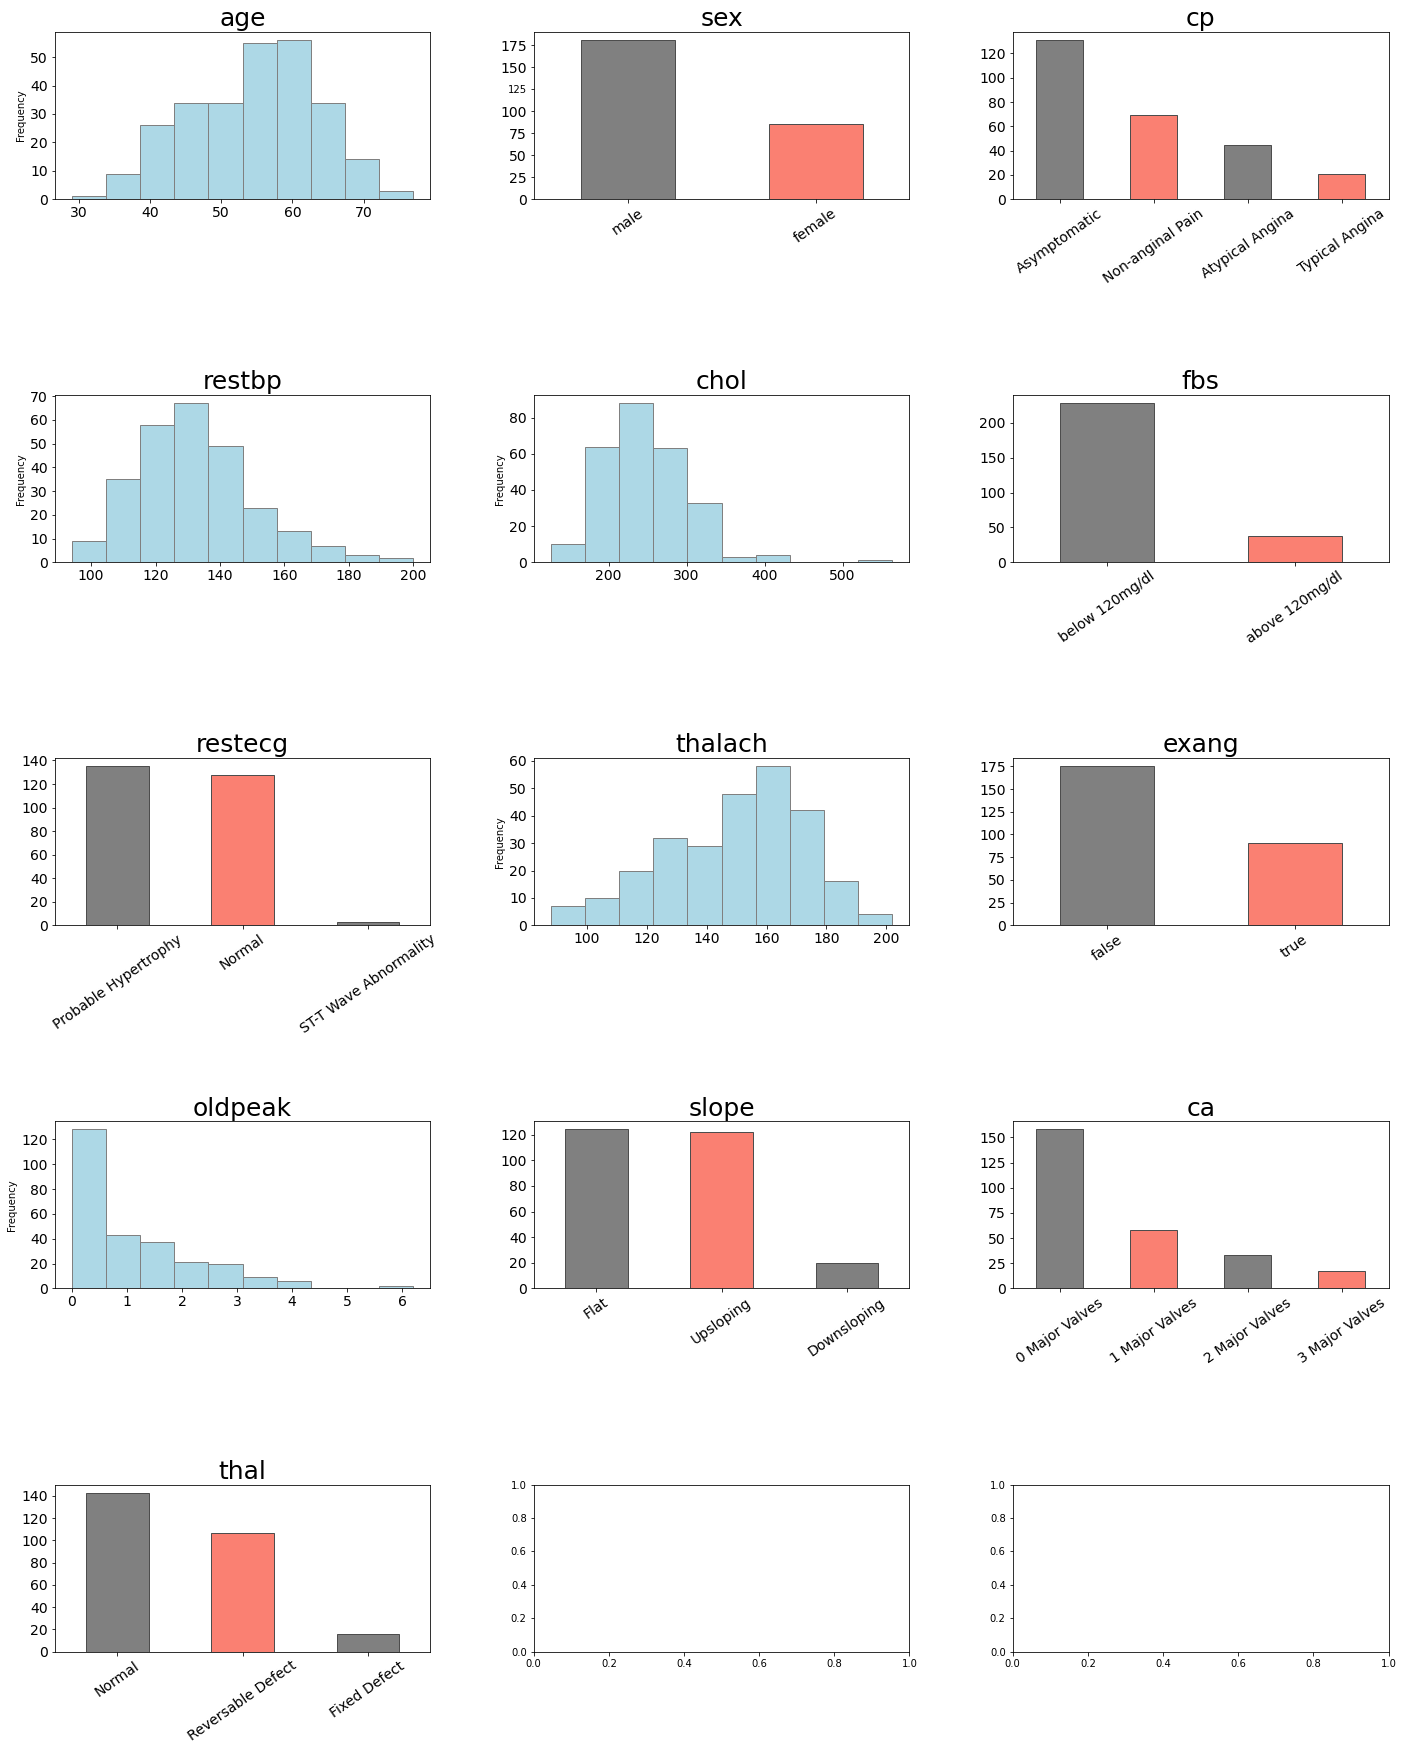

In [107]:
multiplots_freq(readable_df.drop('target', axis=1), filename='images/1_freq_plots', h=25, axis_width=3)

/home/jade/repos/ml_heart_disease/.heartdisease_env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/jade/repos/ml_heart_disease/.heartdisease_env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/jade/repos/ml_heart_disease/.heartdisease_env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/j

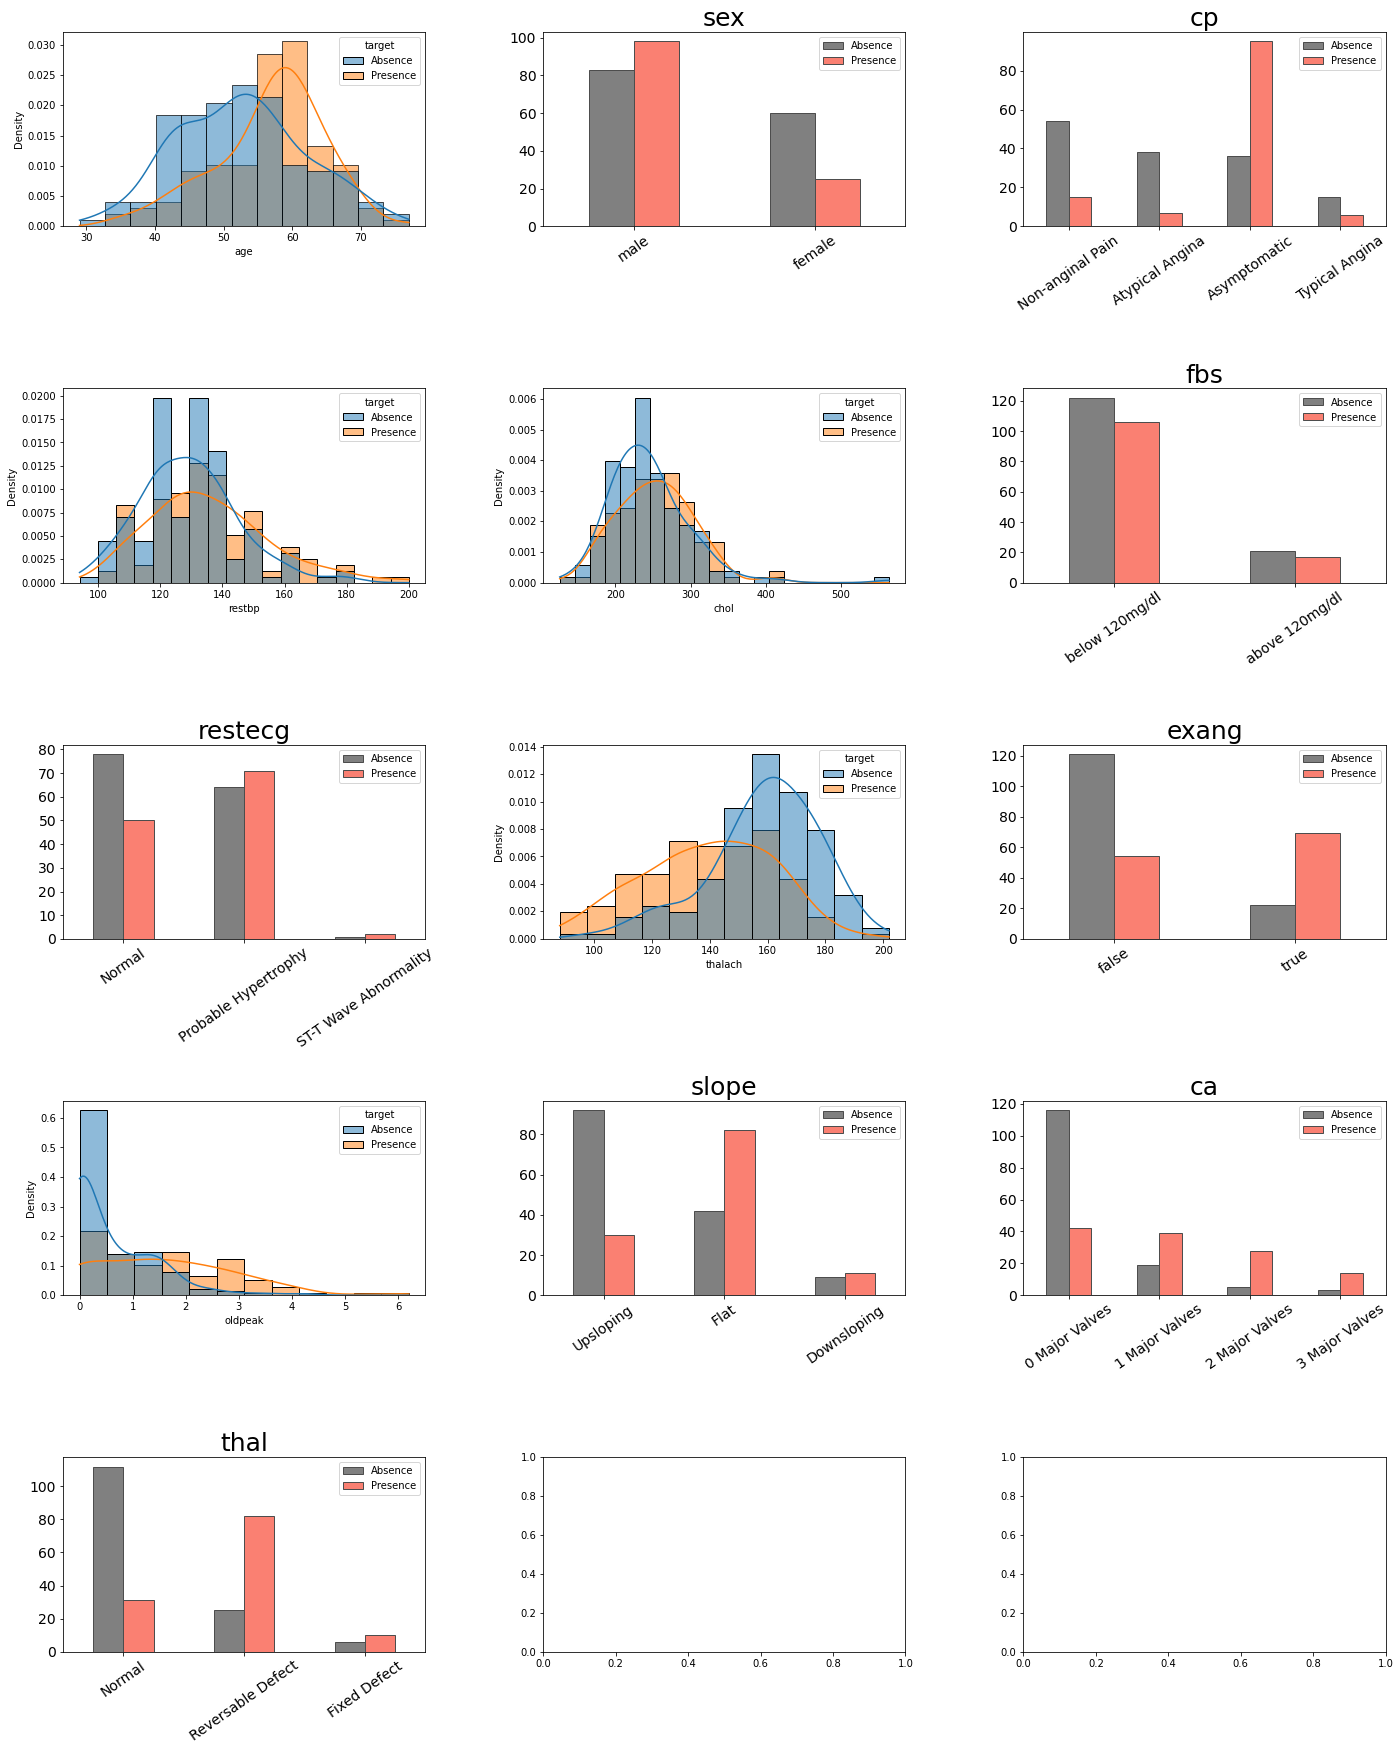

In [108]:
multiplots_freq_target(readable_df, filename='images/2_target_freq_plots', h=25, axis_width=3)

Notes:

- Age slightly skewed
- Double the amount of men as women
- 2 ? in thal and 4 in ca - Need to be removed. (Can do imputation) (Find out how significant their combinations are)
- Maybe combine restecg 1 and 2
- Thalach eases overlap a little towards lower end of scale (145)
- Oldpeak eases overlap towards higher values (1.5)
- All hists show skewed distribution (Scaling/ Normalisation needed?)

## Correlation between features

The following heatmap shows that there is little correlation between our features. The highest correlation that we find is 0.59 which is still below 0.6 and therefore below a strong correlation threshold.

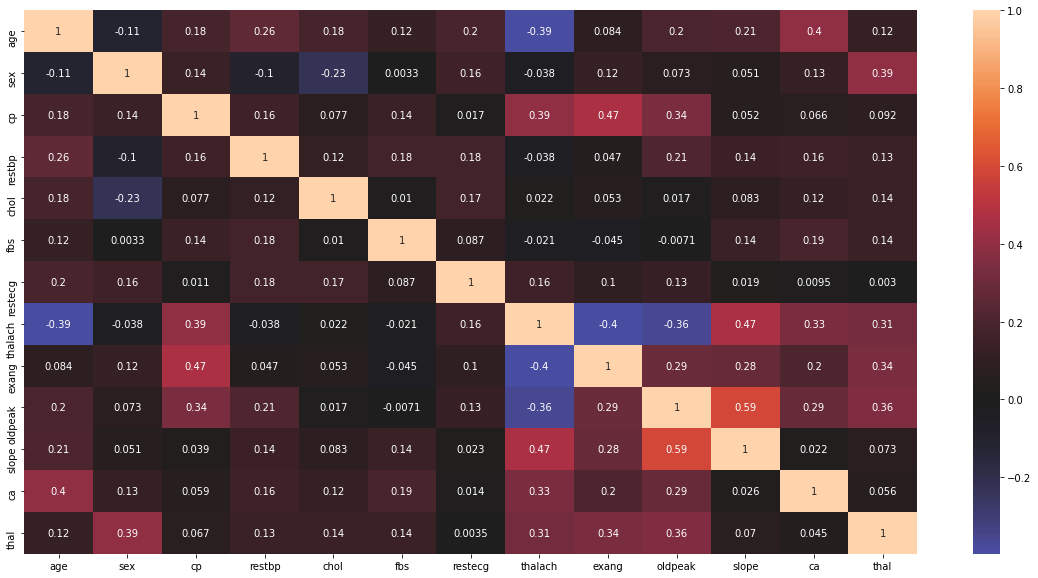

In [109]:
corr_mat_df = pd.DataFrame(create_corr_matrix(train_test_df.drop('target', axis=1)))
corr_mat_df = corr_mat_df.set_index(train_test_df.drop('target', axis=1).columns)
corr_mat_df.head()

plt.figure(figsize = (20,10))
ax = sns.heatmap(corr_mat_df, annot=True, center=0)

## Feature Engineering

From the above EDA analysis, we can identify a number of features that could be transformed to improve model performance. By encoding features thal and chest pain type into binary and tranforming slope and ca into one-hot encoding, we aim to both generalise and improve model performance.